In [1]:
import sagemaker
from sagemaker import get_execution_role
import boto3
import sagemaker
import os, sys
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the SageMaker session
role = get_execution_role()  # This retrieves your execution role automatically
session = sagemaker.Session()
sess   = sagemaker.Session()
region = boto3.Session().region_name
bucket = sess.default_bucket()  

# Define your S3 bucket and folder prefix for storing input/output data
bucket_name = 'my-sagemaker-bucket'  # Replace with your actual bucket name
prefix = 'ads-xgboost-project'       # Folder in S3 to store model data

# S3 paths for data input/output
input_data_path = f's3://{bucket_name}/{prefix}/input'
output_data_path = f's3://{bucket_name}/{prefix}/output'

# Print paths to confirm they are correct
print(f'Input data path: {input_data_path}')
print(f'Output data path: {output_data_path}')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Input data path: s3://my-sagemaker-bucket/ads-xgboost-project/input
Output data path: s3://my-sagemaker-bucket/ads-xgboost-project/output


In [2]:
sm = boto3.Session().client(service_name='sagemaker',region_name=region)
sm_rt = boto3.Session().client('runtime.sagemaker', region_name=region)

In [3]:

print(os.getcwd())

/home/sagemaker-user/Final


In [4]:
 # https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html
data = pd.read_csv('/home/sagemaker-user/Final/dataset.csv')
pd.set_option('display.max_columns', 500)     # Make sure we can see all of the columns
pd.set_option('display.max_rows', 50)         # Keep the output on one page
data[:10] # Show the

Marital status  Application mode  Application order  Course  \
0               1                 8                  5       2   
1               1                 6                  1      11   
2               1                 1                  5       5   
3               1                 8                  2      15   
4               2                12                  1       3   
5               2                12                  1      17   
6               1                 1                  1      12   
7               1                 9                  4      11   
8               1                 1                  3      10   
9               1                 1                  1      10   

   Daytime/evening attendance  Previous qualification  Nacionality  \
0                           1                       1            1   
1                           1                       1            1   
2                           1                       1            1   
3                           1                       1            1   
4                           0                       1            1   
5                           0                      12            1   
6                           1                       1            1   
7                           1                       1            1   
8                           1                       1           15   
9                           1                       1            1   

   Mother's qualification  Father's qualification  Mother's occupation  \
0                      13                      10                    6   
1                       1                       3                    4   
2                      22                      27                   10   
3                      23                      27                    6   
4                      22                      28                   10   
5                      22                      27                   10   
6                      13                      28                    8   
7                      22                      27                   10   
8                       1                       1                   10   
9                       1                      14                    5   

   Father's occupation  Displaced  Educational special needs  Debtor  \
0                   10          1                          0       0   
1                    4          1                          0       0   
2                   10          1                          0       0   
3                    4          1                          0       0   
4                   10          0                          0       0   
5                    8          0                          0       1   
6                   11          1                          0       0   
7                   10          1                          0       0   
8                   10          0                          0       0   
9                    8          1                          0       1   

   Tuition fees up to date  Gender  Scholarship holder  Age at enrollment  \
0                        1       1                   0                 20   
1                        0       1                   0                 19   
2                        0       1                   0                 19   
3                        1       0                   0                 20   
4                        1       0                   0                 45   
5                        1       1                   0                 50   
6                        1       0                   1                 18   
7                        0       1                   0                 22   
8                        1       0                   1                 21   
9                        0       0                   0                 18   

   International  Curricular units 1st sem (credi

In [5]:
data.shape # (number of lines, number of columns)

(4424, 35)

In [6]:
print(data.isna().sum())
print("Total Missing: ", data.isna().sum().sum())

Marital status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance                        0
Previous qualification                            0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                                0
Age at enrollment                                 0
International                                     0
Curricular u

In [7]:
print("Total Duplicates: ", data.duplicated().sum())

Total Duplicates:  0


In [8]:
data["Target"].value_counts()

Target
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64

/tmp/ipykernel_3017/3591118126.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x="Target", palette="viridis")


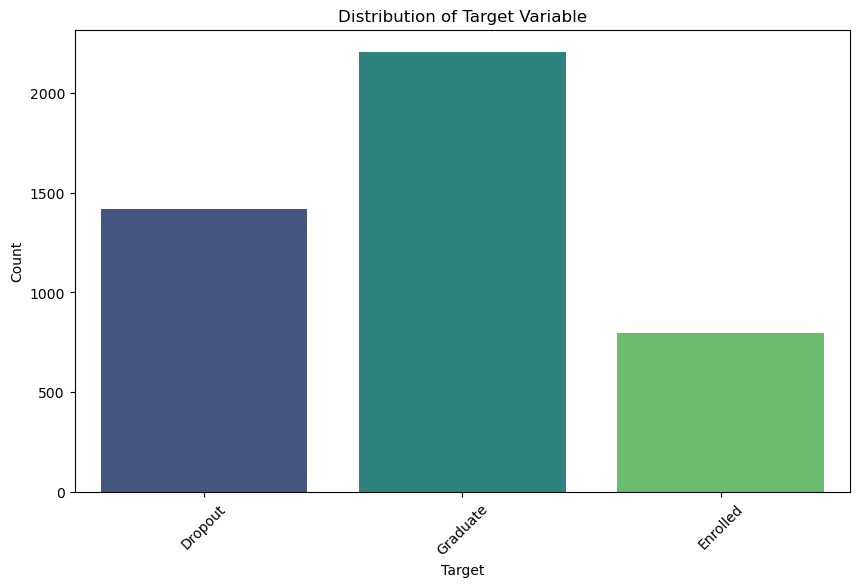

In [9]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x="Target", palette="viridis")
plt.title("Distribution of Target Variable")
plt.xlabel("Target")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [10]:
data = data[data.Target != "Enrolled"]

In [11]:
data.shape


(3630, 35)

In [12]:
freq_distribution = data["Target"].value_counts().to_frame(name="Count")
freq_distribution["% of Total"] = (
    data["Target"].value_counts(normalize=True) * 100
).round(2)
freq_distribution

Count  % of Total
Target                     
Graduate   2209       60.85
Dropout    1421       39.15

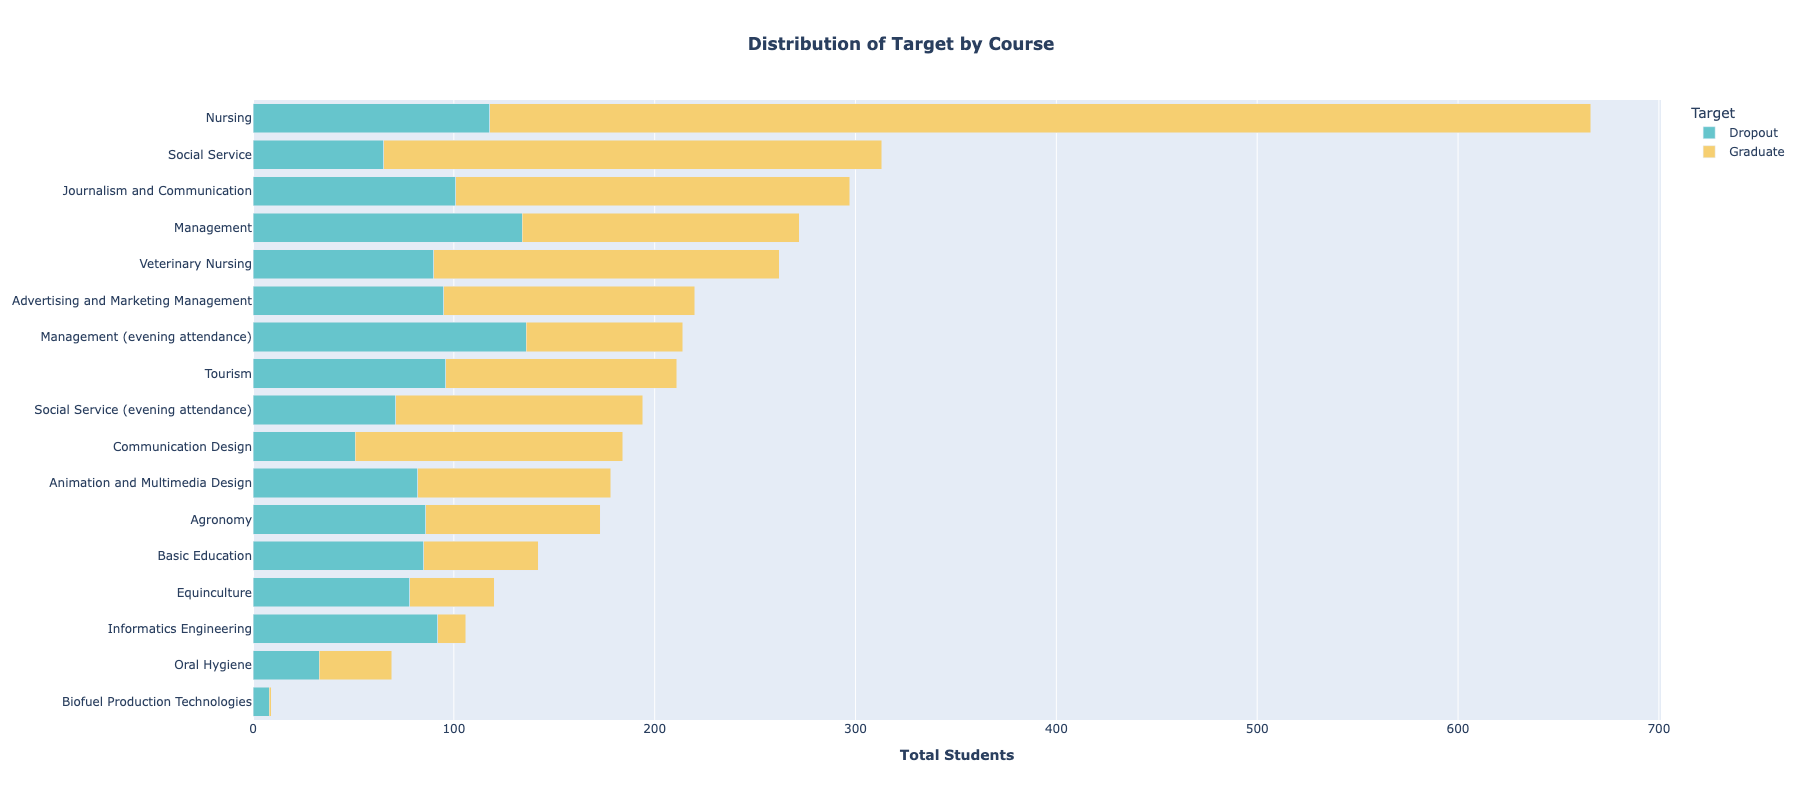

In [13]:
import plotly.express as px

# Group by Course and Target
student_courses = (
    data.groupby(["Course", "Target"])
    .size()
    .reset_index()
    .pivot(columns="Target", index="Course", values=0)
)
student_courses = student_courses.rename(
    index={
        1: "Biofuel Production Technologies",
        2: "Animation and Multimedia Design",
        3: "Social Service (evening attendance)",
        4: "Agronomy",
        5: "Communication Design",
        6: "Veterinary Nursing",
        7: "Informatics Engineering",
        8: "Equinculture",
        9: "Management",
        10: "Social Service",
        11: "Tourism",
        12: "Nursing",
        13: "Oral Hygiene",
        14: "Advertising and Marketing Management",
        15: "Journalism and Communication",
        16: "Basic Education",
        17: "Management (evening attendance)",
    }
)

# Ensure the 'Dropout' column exists
if "Dropout" not in student_courses.columns:
    student_courses["Dropout"] = student_courses[0]  # Assuming '0' represents dropouts

# Sum the total number of students for each course and sort for the plot
student_courses["Total"] = student_courses.sum(axis=1)
student_courses_sorted = student_courses.sort_values(by="Total", ascending=True)

# Remove the 'Total' column
student_courses_sorted.drop(columns="Total", inplace=True)

# Generate the interactive plot
fig = px.bar(
    student_courses_sorted,
    orientation="h",
    title="Distribution of Target by Course",
    labels={"value": "Total Students", "Course": "Course"},
    color_discrete_sequence=px.colors.qualitative.Pastel,
)

# Customize the layout
fig.update_layout(
    title={"text": "<b>Distribution of Target by Course</b>", "x": 0.5},
    xaxis_title="<b>Total Students</b>",
    yaxis_title=None,
    barmode="stack",
    width=1200,  # Increase the width
    height=800,  # Increase the height
)

# Show the plot
fig.show()

In [14]:
# Calculate the Dropout Rate and Graduate Rate
student_courses_sorted["Dropout Rate"] = (
    student_courses_sorted["Dropout"] / student_courses_sorted.sum(axis=1) * 100
).round(3)
student_courses_sorted["Graduate Rate"] = (
    student_courses_sorted["Graduate"] / student_courses_sorted.sum(axis=1) * 100
).round(3)

# Create a new DataFrame with only Dropout Rate and Graduate Rate
dropout_graduate_rates = student_courses_sorted[
    ["Dropout Rate", "Graduate Rate"]
].copy()

# Display the new DataFrame
dropout_graduate_rates

Target                                Dropout Rate  Graduate Rate
Course                                                           
Biofuel Production Technologies             88.889          1.022
Oral Hygiene                                47.826         30.815
Informatics Engineering                     86.792          7.262
Equinculture                                65.000         22.703
Basic Education                             59.859         28.238
Agronomy                                    49.711         39.064
Animation and Multimedia Design             46.067         42.844
Communication Design                        27.717         62.820
Social Service (evening attendance)         36.598         53.340
Tourism                                     45.498         44.835
Management (evening attendance)             63.551         28.103
Advertising and Marketing Management        43.182         47.496
Veterinary Nursing                          34.351         58.039
Management                                  49.265         42.955
Journalism and Communication                34.007         59.213
Social Service                              20.767         74.303
Nursing                                     17.718         80.150

In [15]:
data= pd.get_dummies(data, columns=["Target"])
data.head()

Marital status  Application mode  Application order  Course  \
0               1                 8                  5       2   
1               1                 6                  1      11   
2               1                 1                  5       5   
3               1                 8                  2      15   
4               2                12                  1       3   

   Daytime/evening attendance  Previous qualification  Nacionality  \
0                           1                       1            1   
1                           1                       1            1   
2                           1                       1            1   
3                           1                       1            1   
4                           0                       1            1   

   Mother's qualification  Father's qualification  Mother's occupation  \
0                      13                      10                    6   
1                       1                       3                    4   
2                      22                      27                   10   
3                      23                      27                    6   
4                      22                      28                   10   

   Father's occupation  Displaced  Educational special needs  Debtor  \
0                   10          1                          0       0   
1                    4          1                          0       0   
2                   10          1                          0       0   
3                    4          1                          0       0   
4                   10          0                          0       0   

   Tuition fees up to date  Gender  Scholarship holder  Age at enrollment  \
0                        1       1                   0                 20   
1                        0       1                   0                 19   
2                        0       1                   0                 19   
3                        1       0                   0                 20   
4                        1       0                   0                 45   

   International  Curricular units 1st sem (credited)  \
0              0                                    0   
1              0                                    0   
2              0                                    0   
3              0                                    0   
4              0                                    0   

   Curricular units 1st sem (enrolled)  \
0                                    0   
1                                    6   
2                                    6   
3                                    6   
4                                    6   

   Curricular units 1st sem (evaluations)  \
0                                       0   
1                                       6   
2                                       0   
3                                       8   
4                                       9   

   Curricular units 1st sem (approved)  Curricular units 1st sem (grade)  \
0                                    0                          0.000000   
1                                    6                         14.000000   
2                                    0                          0.000000   
3                                    6                         13.428571   
4                                    5                         12.333333   

   Curricular units 1st sem (without evaluations)  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   

   Curricular units 2nd sem (credited)  Curricular units 2nd sem (enrolled)  \
0                                    0                                    0   
1                                    0     

In [16]:
dummies_to_drop = ["Target_Graduate"]
data.drop(columns=dummies_to_drop, inplace=True)
data.rename(columns={"Target_Dropout": "Target"}, inplace=True)

data.head()

Marital status  Application mode  Application order  Course  \
0               1                 8                  5       2   
1               1                 6                  1      11   
2               1                 1                  5       5   
3               1                 8                  2      15   
4               2                12                  1       3   

   Daytime/evening attendance  Previous qualification  Nacionality  \
0                           1                       1            1   
1                           1                       1            1   
2                           1                       1            1   
3                           1                       1            1   
4                           0                       1            1   

   Mother's qualification  Father's qualification  Mother's occupation  \
0                      13                      10                    6   
1                       1                       3                    4   
2                      22                      27                   10   
3                      23                      27                    6   
4                      22                      28                   10   

   Father's occupation  Displaced  Educational special needs  Debtor  \
0                   10          1                          0       0   
1                    4          1                          0       0   
2                   10          1                          0       0   
3                    4          1                          0       0   
4                   10          0                          0       0   

   Tuition fees up to date  Gender  Scholarship holder  Age at enrollment  \
0                        1       1                   0                 20   
1                        0       1                   0                 19   
2                        0       1                   0                 19   
3                        1       0                   0                 20   
4                        1       0                   0                 45   

   International  Curricular units 1st sem (credited)  \
0              0                                    0   
1              0                                    0   
2              0                                    0   
3              0                                    0   
4              0                                    0   

   Curricular units 1st sem (enrolled)  \
0                                    0   
1                                    6   
2                                    6   
3                                    6   
4                                    6   

   Curricular units 1st sem (evaluations)  \
0                                       0   
1                                       6   
2                                       0   
3                                       8   
4                                       9   

   Curricular units 1st sem (approved)  Curricular units 1st sem (grade)  \
0                                    0                          0.000000   
1                                    6                         14.000000   
2                                    0                          0.000000   
3                                    6                         13.428571   
4                                    5                         12.333333   

   Curricular units 1st sem (without evaluations)  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   

   Curricular units 2nd sem (credited)  Curricular units 2nd sem (enrolled)  \
0                                    0                                    0   
1                                    0     

In [17]:
# Set display options to show all columns and rows
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# Calculate the correlation matrix and round it to 2 decimal places
correlation_matrix = data.corr().round(2)

# Display the correlation matrix
correlation_matrix

# Reset display options to default values
pd.reset_option("display.max_columns")
pd.reset_option("display.max_rows")

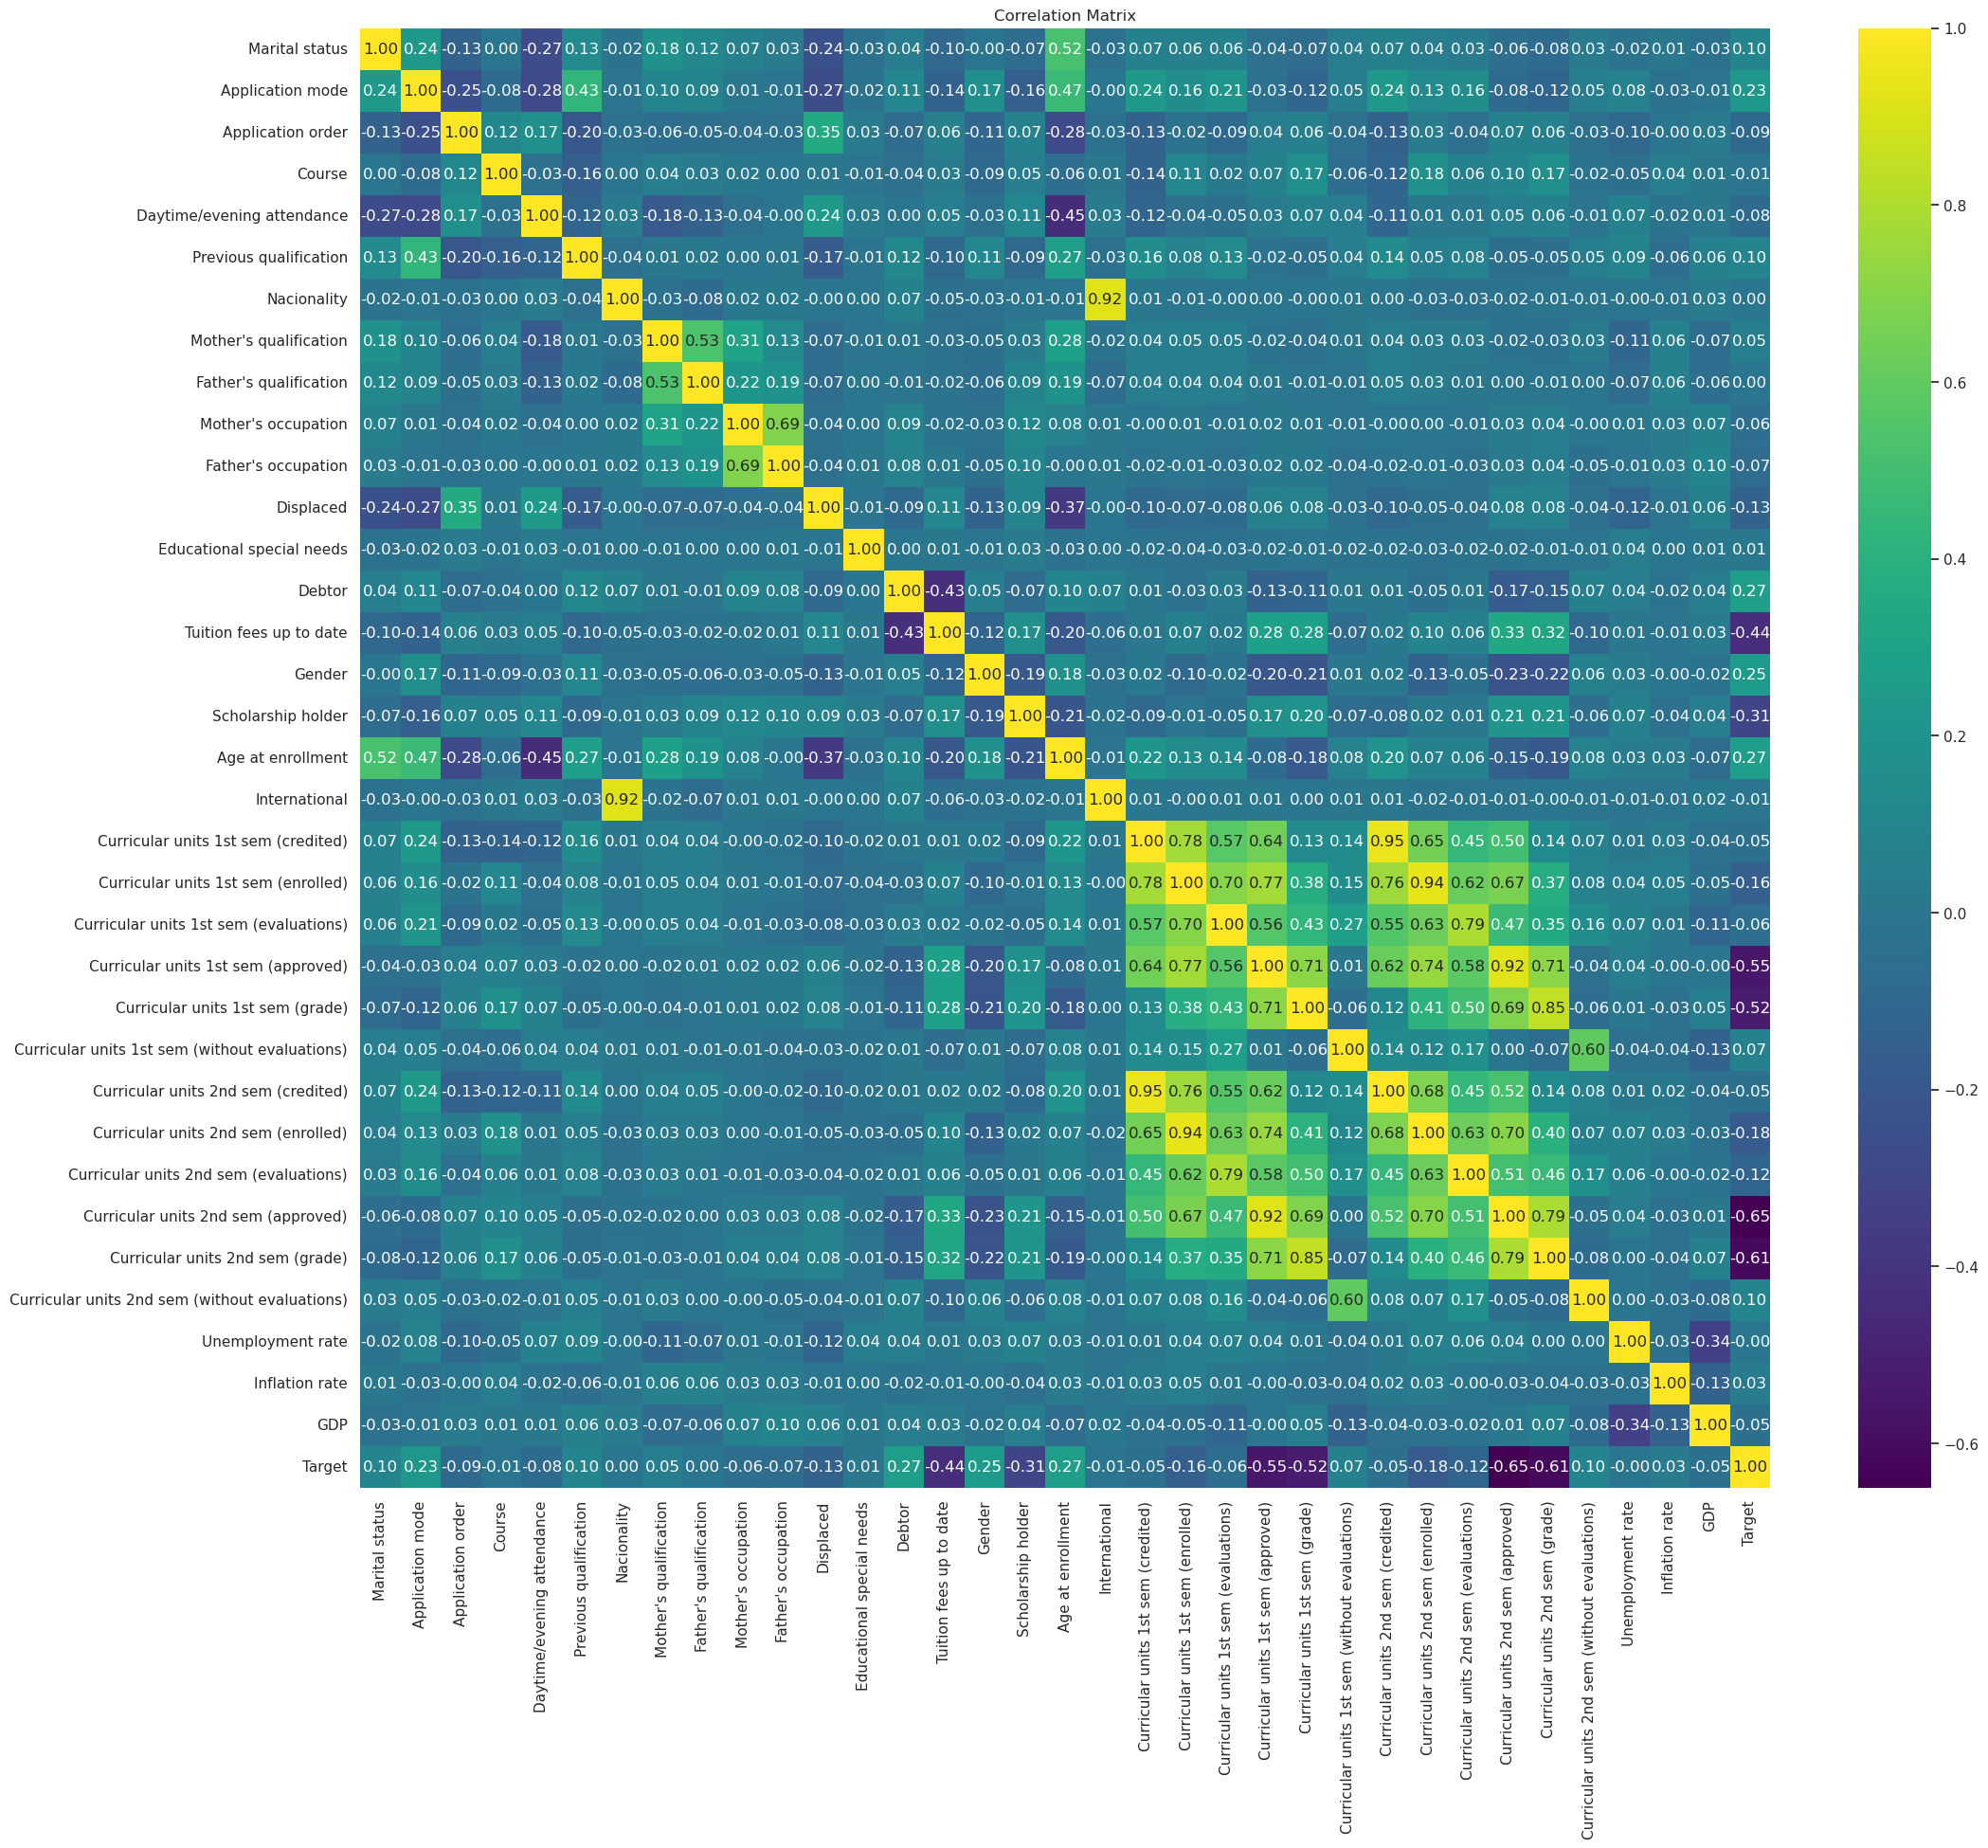

In [18]:
sns.set(rc={"figure.figsize": (24, 20)})  # Increased the figure size
sns.heatmap(correlation_matrix, annot=True, cmap="viridis", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [20]:
data.rename(columns={"Nacionality": "Nationality"}, inplace=True)

In [21]:
# Demographic
demographics = data[
    [
        "Marital status",
        "Nationality",
        "Displaced",
        "Gender",
        "Age at enrollment",
        "International",
        "Target",
    ]
]
# Academic
academic_path = data[
    [
        "Curricular units 1st sem (credited)",
        "Curricular units 1st sem (enrolled)",
        "Curricular units 1st sem (evaluations)",
        "Curricular units 1st sem (approved)",
        "Curricular units 1st sem (grade)",
        "Curricular units 1st sem (without evaluations)",
        "Curricular units 2nd sem (credited)",
        "Curricular units 2nd sem (enrolled)",
        "Curricular units 2nd sem (evaluations)",
        "Curricular units 2nd sem (approved)",
        "Curricular units 2nd sem (grade)",
        "Curricular units 2nd sem (without evaluations)",
        "Target",
    ]
]

In [22]:
features_to_drop = ["Nationality", "International"]
features_to_drop

['Nationality', 'International']

In [23]:
features_to_drop.extend(
    [
        "Curricular units 1st sem (credited)",
        "Curricular units 1st sem (enrolled)",
        "Curricular units 1st sem (evaluations)",
        "Curricular units 1st sem (approved)",
        "Curricular units 1st sem (grade)",
        "Curricular units 1st sem (without evaluations)",
        "Curricular units 2nd sem (credited)",
        "Curricular units 2nd sem (without evaluations)",
    ]
)
features_to_drop

['Nationality',
 'International',
 'Curricular units 1st sem (credited)',
 'Curricular units 1st sem (enrolled)',
 'Curricular units 1st sem (evaluations)',
 'Curricular units 1st sem (approved)',
 'Curricular units 1st sem (grade)',
 'Curricular units 1st sem (without evaluations)',
 'Curricular units 2nd sem (credited)',
 'Curricular units 2nd sem (without evaluations)']

In [24]:
data.drop(features_to_drop, axis=1, inplace=True)
data.head()

Marital status  Application mode  Application order  Course  \
0               1                 8                  5       2   
1               1                 6                  1      11   
2               1                 1                  5       5   
3               1                 8                  2      15   
4               2                12                  1       3   

   Daytime/evening attendance  Previous qualification  Mother's qualification  \
0                           1                       1                      13   
1                           1                       1                       1   
2                           1                       1                      22   
3                           1                       1                      23   
4                           0                       1                      22   

   Father's qualification  Mother's occupation  Father's occupation  ...  \
0                      10                    6                   10  ...   
1                       3                    4                    4  ...   
2                      27                   10                   10  ...   
3                      27                    6                    4  ...   
4                      28                   10                   10  ...   

   Scholarship holder  Age at enrollment  Curricular units 2nd sem (enrolled)  \
0                   0                 20                                    0   
1                   0                 19                                    6   
2                   0                 19                                    6   
3                   0                 20                                    6   
4                   0                 45                                    6   

   Curricular units 2nd sem (evaluations)  \
0                                       0   
1                                       6   
2                                       0   
3                                      10   
4                                       6   

   Curricular units 2nd sem (approved)  Curricular units 2nd sem (grade)  \
0                                    0                          0.000000   
1                                    6                         13.666667   
2                                    0                          0.000000   
3                                    5                         12.400000   
4                                    6                         13.000000   

   Unemployment rate  Inflation rate   GDP  Target  
0               10.8             1.4  1.74    True  
1               13.9            -0.3  0.79   False  
2               10.8             1.4  1.74    True  
3                9.4            -0.8 -3.12   False  
4               13.9            -0.3  0.79   False  

[5 rows x 25 columns]

In [26]:
data.to_csv("new_dataframe.csv", index=False)
print("New DataFrame saved as new_dataframe.csv locally.")

New DataFrame saved as new_dataframe.csv locally.


In [27]:
# 2. Upload the saved CSV file to your S3 bucket using SageMaker session
sess = sagemaker.Session()

# Define your S3 bucket and folder (prefix)
bucket_name = 'your-sagemaker-bucket'  # Replace with your actual bucket name
prefix = 'ads-xgboost-project'         # Folder in S3 to store model data

# Upload the CSV file to S3
s3_output_path = sess.upload_data(path="new_dataframe.csv", key_prefix=prefix + "/new_data")
print(f"New DataFrame uploaded to: {s3_output_path}")

New DataFrame uploaded to: s3://sagemaker-us-west-1-559050229504/ads-xgboost-project/new_data/new_dataframe.csv


In [28]:
print(os.getcwd())

/home/sagemaker-user/Final


In [32]:
New_data = pd.read_csv('/home/sagemaker-user/Final/new_dataframe.csv')
pd.set_option('display.max_columns', 500)     # Make sure we can see all of the columns
pd.set_option('display.max_rows', 50)         # Keep the output on one page
New_data[:10] # Show the first 10 lines

Marital status  Application mode  Application order  Course  \
0               1                 8                  5       2   
1               1                 6                  1      11   
2               1                 1                  5       5   
3               1                 8                  2      15   
4               2                12                  1       3   
5               2                12                  1      17   
6               1                 1                  1      12   
7               1                 9                  4      11   
8               1                 1                  3      10   
9               1                 1                  1      10   

   Daytime/evening attendance  Previous qualification  Mother's qualification  \
0                           1                       1                      13   
1                           1                       1                       1   
2                           1                       1                      22   
3                           1                       1                      23   
4                           0                       1                      22   
5                           0                      12                      22   
6                           1                       1                      13   
7                           1                       1                      22   
8                           1                       1                       1   
9                           1                       1                       1   

   Father's qualification  Mother's occupation  Father's occupation  \
0                      10                    6                   10   
1                       3                    4                    4   
2                      27                   10                   10   
3                      27                    6                    4   
4                      28                   10                   10   
5                      27                   10                    8   
6                      28                    8                   11   
7                      27                   10                   10   
8                       1                   10                   10   
9                      14                    5                    8   

   Displaced  Educational special needs  Debtor  Tuition fees up to date  \
0          1                          0       0                        1   
1          1                          0       0                        0   
2          1                          0       0                        0   
3          1                          0       0                        1   
4          0                          0       0                        1   
5          0                          0       1                        1   
6          1                          0       0                        1   
7          1                          0       0                        0   
8          0                          0       0                        1   
9          1                          0       1                        0   

   Gender  Scholarship holder  Age at enrollment  \
0       1                   0                 20   
1       1                   0                 19   
2       1                   0                 19   
3       0                   0                 20   
4       0                   0                 45   
5       1                   0                 50   
6       0                   1                 18   
7       1                   0                 22   
8       0                   1                 21   
9       0                   0                 18   

   Curricular units 2nd sem (enrolled)  \
0                                    0   
1                                    6   
2                                    6   
3                       

In [33]:
 data.shape # (number of lines, number of columns)

(3630, 25)

In [34]:
# Set the seed to 123 for reproductibility
# https://pandas.pydata.org/pandas-docs/version/0.25/generated/pandas.DataFrame.sample.html
# https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.split.html
train_data, test_data, _ = np.split(data.sample(frac=1, random_state=123), 
                                                  [int(0.95 * len(data)), int(len(data))])  

# Save to CSV files
train_data.to_csv('automl-train.csv', index=False, header=True, sep=',') # Need to keep column names
test_data.to_csv('automl-test.csv', index=False, header=True, sep=',')

/opt/conda/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning:

'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.



In [36]:
!ls -l automl*.csv

-rw-r--r-- 1 sagemaker-user users  13793 Oct 12 05:32 automl-test.csv
-rw-r--r-- 1 sagemaker-user users 255160 Oct 12 05:32 automl-train.csv


In [37]:
sess.upload_data(path="automl-train.csv", key_prefix=prefix + "/input")

's3://sagemaker-us-west-1-559050229504/ads-xgboost-project/input/automl-train.csv'

In [38]:
 job_config = {
    'CompletionCriteria': {
      'MaxRuntimePerTrainingJobInSeconds': 600,
      # 'MaxCandidates': 10,
      'MaxAutoMLJobRuntimeInSeconds': 3600
    },
}

input_data_config = [{
      'DataSource': {
        'S3DataSource': {
          'S3DataType': 'S3Prefix',
          'S3Uri': 's3://{}/{}/input'.format(bucket,prefix)
        }
      },
      'TargetAttributeName': 'Target'  # the column we want to predict
    }
]

output_data_config = { 'S3OutputPath': 's3://{}/{}/output'.format(bucket,prefix) }

# Optional parameters

problem_type = 'BinaryClassification'

job_objective = { 'MetricName': 'F1' }

In [39]:
from time import gmtime, strftime, sleep
timestamp_suffix = strftime('%d-%H-%M-%S', gmtime())

auto_ml_job_name = 'automl-dm-' + timestamp_suffix
print('AutoMLJobName: ' + auto_ml_job_name)

sm.create_auto_ml_job(AutoMLJobName=auto_ml_job_name,
                      InputDataConfig=input_data_config,
                      OutputDataConfig=output_data_config,
                      AutoMLJobConfig=job_config,
                      AutoMLJobObjective=job_objective,
                      ProblemType=problem_type,
                      RoleArn=role)

AutoMLJobName: automl-dm-12-05-33-27


{'AutoMLJobArn': 'arn:aws:sagemaker:us-west-1:559050229504:automl-job/automl-dm-12-05-33-27',
 'ResponseMetadata': {'RequestId': 'f3524621-5d2b-4d88-84ec-a98ae90d3bf0',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'f3524621-5d2b-4d88-84ec-a98ae90d3bf0',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '92',
   'date': 'Sat, 12 Oct 2024 05:33:28 GMT'},
  'RetryAttempts': 0}}

In [40]:
 %%time
job_run_status = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)['AutoMLJobStatus']

print(job_run_status)

while job_run_status not in ('Failed', 'Completed', 'Stopped'):
    describe_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
    job_run_status = describe_response['AutoMLJobStatus']
    
    print (describe_response['AutoMLJobStatus'] + " - " + describe_response['AutoMLJobSecondaryStatus'])
    sleep(60)

InProgress
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTun

In [43]:
 from sagemaker.analytics import ExperimentAnalytics

analytics = ExperimentAnalytics(
    sagemaker_session=sess, 
    experiment_name=auto_ml_job_name+'-aws-auto-ml-job'
)

df = analytics.dataframe()
df

TrialComponentName  \
0    automl-dm-12-05-33-27Ut57g2DQ2Dz-100-1ae0cf4e-...   
1    automl-dm-12-05-33-27Ut57g2DQ2Dz-089-6584dc48-...   
2    automl-dm-12-05-33-27Ut57g2DQ2Dz-094-cd90a083-...   
3    automl-dm-12-05-33-27Ut57g2DQ2Dz-092-4fd5f3af-...   
4    automl-dm-12-05-33-27Ut57g2DQ2Dz-091-92d0cca7-...   
..                                                 ...   
110  automl-dm-12-05-33-27-dpp0-1-8c3c07e88a07460f8...   
111  automl-dm-12-05-33-27-dpp3-1-db3023f838714162a...   
112  automl-dm-12-05-33-27-dpp4-1-f9971d4531f84c52a...   
113  automl-dm-12-05-33-27-dpp5-1-acca8e74d7de47b88...   
114  automl-dm-12-05-33-27-db-1-040fd7898ca840da9ed...   

                                           DisplayName  \
0    automl-dm-12-05-33-27Ut57g2DQ2Dz-100-1ae0cf4e-...   
1    automl-dm-12-05-33-27Ut57g2DQ2Dz-089-6584dc48-...   
2    automl-dm-12-05-33-27Ut57g2DQ2Dz-094-cd90a083-...   
3    automl-dm-12-05-33-27Ut57g2DQ2Dz-092-4fd5f3af-...   
4    automl-dm-12-05-33-27Ut57g2DQ2Dz-091-92d0cca7-...   
..                                                 ...   
110  automl-dm-12-05-33-27-dpp0-1-8c3c07e88a07460f8...   
111  automl-dm-12-05-33-27-dpp3-1-db3023f838714162a...   
112  automl-dm-12-05-33-27-dpp4-1-f9971d4531f84c52a...   
113  automl-dm-12-05-33-27-dpp5-1-acca8e74d7de47b88...   
114  automl-dm-12-05-33-27-db-1-040fd7898ca840da9ed...   

                                             SourceArn  \
0    arn:aws:sagemaker:us-west-1:559050229504:train...   
1    arn:aws:sagemaker:us-west-1:559050229504:train...   
2    arn:aws:sagemaker:us-west-1:559050229504:train...   
3    arn:aws:sagemaker:us-west-1:559050229504:train...   
4    arn:aws:sagemaker:us-west-1:559050229504:train...   
..                                                 ...   
110  arn:aws:sagemaker:us-west-1:559050229504:train...   
111  arn:aws:sagemaker:us-west-1:559050229504:train...   
112  arn:aws:sagemaker:us-west-1:559050229504:train...   
113  arn:aws:sagemaker:us-west-1:559050229504:train...   
114  arn:aws:sagemaker:us-west-1:559050229504:proce...   

                                    SageMaker.ImageUri  \
0    632365934929.dkr.ecr.us-west-1.amazonaws.com/m...   
1    746614075791.dkr.ecr.us-west-1.amazonaws.com/s...   
2    746614075791.dkr.ecr.us-west-1.amazonaws.com/s...   
3    746614075791.dkr.ecr.us-west-1.amazonaws.com/s...   
4    746614075791.dkr.ecr.us-west-1.amazonaws.com/s...   
..                                                 ...   
110  746614075791.dkr.ecr.us-west-1.amazonaws.com/s...   
111  746614075791.dkr.ecr.us-west-1.amazonaws.com/s...   
112  746614075791.dkr.ecr.us-west-1.amazonaws.com/s...   
113  746614075791.dkr.ecr.us-west-1.amazonaws.com/s...   
114                                                NaN   

     SageMaker.InstanceCount SageMaker.InstanceType  SageMaker.VolumeSizeInGB  \
0                        1.0          ml.m5.4xlarge                      50.0   
1                        1.0          ml.m5.4xlarge                      50.0   
2                        1.0          ml.m5.4xlarge                      50.0   
3                        1.0          ml.m5.4xlarge                      50.0   
4                        1.0          ml.m5.4xlarge                      50.0   
..                       ...                    ...                       ...   
110                      1.0          ml.m5.4xlarge                      50.0   
111                      1.0          ml.m5.4xlarge                      50.0   
112                      1.0          ml.m5.4xlarge                      50.0   
113                      1.0          ml.m5.4xlarge                      50.0   
114                      1.0          ml.m5.2xlarge                     250.0   

     _tuning_objective_metric activation  dropout_prob  embedding_size_factor  \
0    validation:binary_f_beta       relu      0.276183               0.762113   
1        validation:f1_binary        NaN           NaN                    NaN   
2        validation:f1_binary   

In [44]:
candidates = sm.list_candidates_for_auto_ml_job(AutoMLJobName=auto_ml_job_name, 
                                                SortBy='FinalObjectiveMetricValue')['Candidates']
index = 1
for candidate in candidates:
  print (str(index) + "  " 
         + candidate['CandidateName'] + "  " 
         + str(candidate['FinalAutoMLJobObjectiveMetric']['Value']))
  index += 1

1  automl-dm-12-05-33-27Ut57g2DQ2Dz-061-fce6b7e7  0.8748499751091003
2  automl-dm-12-05-33-27Ut57g2DQ2Dz-016-628521a3  0.8732100129127502
3  automl-dm-12-05-33-27Ut57g2DQ2Dz-008-d0eccb92  0.8710399866104126
4  automl-dm-12-05-33-27Ut57g2DQ2Dz-012-f7dd0822  0.8707500100135803
5  automl-dm-12-05-33-27Ut57g2DQ2Dz-066-18f85453  0.8697999715805054
6  automl-dm-12-05-33-27Ut57g2DQ2Dz-019-7370dfac  0.8697699904441833
7  automl-dm-12-05-33-27Ut57g2DQ2Dz-017-b6c12bc5  0.8695200085639954
8  automl-dm-12-05-33-27Ut57g2DQ2Dz-001-60d9c877  0.8690900206565857
9  automl-dm-12-05-33-27Ut57g2DQ2Dz-003-e9a8ea27  0.8689799904823303
10  automl-dm-12-05-33-27Ut57g2DQ2Dz-007-001575d3  0.8687000274658203


In [45]:
best_candidate = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)['BestCandidate']
best_candidate_name = best_candidate['CandidateName']

print("Candidate name: " + best_candidate_name)

Candidate name: automl-dm-12-05-33-27Ut57g2DQ2Dz-061-fce6b7e7


In [46]:
for container in best_candidate['InferenceContainers']:
    print(container['Image'])
    print(container['ModelDataUrl'])
    print('-')

746614075791.dkr.ecr.us-west-1.amazonaws.com/sagemaker-sklearn-automl:2.5-1-cpu-py3
s3://sagemaker-us-west-1-559050229504/ads-xgboost-project/output/automl-dm-12-05-33-27/data-processor-models/automl-dm-12-05-33-27-dpp5-1-acca8e74d7de47b884d3605e0ea0a165db/output/model.tar.gz
-
746614075791.dkr.ecr.us-west-1.amazonaws.com/sagemaker-xgboost:1.3-1-cpu-py3
s3://sagemaker-us-west-1-559050229504/ads-xgboost-project/output/automl-dm-12-05-33-27/tuning/automl-dm--dpp5-xgb/automl-dm-12-05-33-27Ut57g2DQ2Dz-061-fce6b7e7/output/model.tar.gz
-
746614075791.dkr.ecr.us-west-1.amazonaws.com/sagemaker-sklearn-automl:2.5-1-cpu-py3
s3://sagemaker-us-west-1-559050229504/ads-xgboost-project/output/automl-dm-12-05-33-27/data-processor-models/automl-dm-12-05-33-27-dpp5-1-acca8e74d7de47b884d3605e0ea0a165db/output/model.tar.gz
-


In [47]:
 model_name = 'automl-dm-model-' + timestamp_suffix

model_arn = sm.create_model(Containers=best_candidate['InferenceContainers'],
                            ModelName=model_name,
                            ExecutionRoleArn=role)

print('Model ARN: ', model_arn['ModelArn'])

Model ARN:  arn:aws:sagemaker:us-west-1:559050229504:model/automl-dm-model-12-05-33-27


In [49]:
 # Don't forget to update the bucket! It must be in the same region as SageMaker
s3_capture_path = 's3://jsimon-capture-uswest1/' + model_name + '/'

print(s3_capture_path)

s3://jsimon-capture-uswest1/automl-dm-model-12-05-33-27/


In [50]:
 data_capture_configuration = {
    "EnableCapture": True, # flag turns data capture on and off
    "DestinationS3Uri": s3_capture_path, # s3 location where captured data is saved
    "InitialSamplingPercentage": 100, # sampling rate to capture data. max is 100%
    "CaptureOptions": [
       {
            "CaptureMode": "Output" # The type of capture this option enables. Values can be: [Output/Input]
        },
        {
            "CaptureMode": "Input" # The type of capture this option enables. Values can be: [Output/Input]
        }
    ],
    "CaptureContentTypeHeader": {
       "CsvContentTypes": ["text/csv"], # headers which should signal to decode the payload into CSV format 
       "JsonContentTypes": ["application/json"] # headers which should signal to decode the payload into JSON format 
    }
}

In [51]:
 # Endpoint configuration name
timestamp_suffix = strftime('%d-%H-%M-%S', gmtime())
epc_name = 'automl-dm-epc-' + timestamp_suffix
print('Endpoint configuration name:', epc_name)

ep_config = sm.create_endpoint_config(EndpointConfigName = epc_name,
                                      ProductionVariants=[{'InstanceType':'ml.m4.xlarge',
                                                           'InitialInstanceCount':1,
                                                           'ModelName':model_name,
                                                           'VariantName': 'AllTraffic'}],
                                      DataCaptureConfig = data_capture_configuration)

Endpoint configuration name: automl-dm-epc-12-06-49-47


In [52]:
# Endpoint name
ep_name = 'automl-dm-ep-' + timestamp_suffix
variant_name = 'automl-dm-variant-' + timestamp_suffix
print('Endpoint name:', ep_name)

create_endpoint_response = sm.create_endpoint(EndpointName=ep_name,
                                              EndpointConfigName=epc_name)

Endpoint name: automl-dm-ep-12-06-49-47


In [53]:
 %%time
sm.get_waiter('endpoint_in_service').wait(EndpointName=ep_name)

resp = sm.describe_endpoint(EndpointName=ep_name)
status = resp['EndpointStatus']

print("Endpoint ARN   : " + resp['EndpointArn'])
print("Endpoint status: " + status)

Endpoint ARN   : arn:aws:sagemaker:us-west-1:559050229504:endpoint/automl-dm-ep-12-06-49-47
Endpoint status: InService
CPU times: user 48.8 ms, sys: 27.6 ms, total: 76.5 ms
Wall time: 4min 30s


In [54]:
tp = tn = fp = fn = count = 0

with open('automl-test.csv') as f:
    lines = f.readlines()
    for l in lines[1:]:   # Skip header
        l = l.split(',')  # Split CSV line into features
        label = l[-1]     # Store 'yes'/'no' label
        l = l[:-1]        # Remove label
        l = ','.join(l)   # Rebuild CSV line without label
                
        response = sm_rt.invoke_endpoint(EndpointName=ep_name, ContentType='text/csv', Accept='text/csv', Body=l)

        response = response['Body'].read().decode("utf-8")
        #print ("label %s response %s" %(label,response))

        if 'yes' in label:
            # Sample is positive
            if 'yes' in response:
                # True positive
                tp=tp+1
            else:
                # False negative
                fn=fn+1
        else:
            # Sample is negative
            if 'no' in response:
                # True negative
                tn=tn+1
            else:
                # False positive
                fp=fp+1
        count = count+1
        if (count % 100 == 0):   
            sys.stdout.write(str(count)+' ')
            
print ("Done")

100 Done


In [57]:
# Confusion matrix
print("%d %d" % (tn, fp))
print("%d %d" % (fn, tp))

# Avoid division by zero by adding checks
if (tp + tn + fp + fn) != 0:
    accuracy = (tp + tn) / (tp + tn + fp + fn)
else:
    accuracy = 0

if (tp + fp) != 0:
    precision = tp / (tp + fp)
else:
    precision = 0

if (tp + fn) != 0:
    recall = tp / (tp + fn)
else:
    recall = 0

if (precision + recall) != 0:
    f1 = (2 * precision * recall) / (precision + recall)
else:
    f1 = 0

print("Accuracy: %.4f, Precision: %.4f, Recall: %.4f, F1: %.4f" % (accuracy, precision, recall, f1))

0 182
0 0
Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


The issue you’re encountering could be related to the split of 95% for training and 5% for testing on a dataset with 4,424 entries. With such a small test set (about 221 instances), it’s possible that some of the classes (like positive labels for the target variable) are not well-represented in the test set. If our target variable is imbalanced, a 5% test set might not contain enough positive samples (or any at all), leading to situations where the true positives (TP) or false negatives (FN) are zero, causing the ZeroDivisionError.

In such cases, it’s common to either:

	1.	Increase the test set size: You can try using a larger portion for the test set (e.g., 80% train and 20% test). This will give the model more data to evaluate and potentially include a better distribution of both positive and negative classes.
	2.	Use stratified sampling: Ensure that the training and test sets maintain the same proportion of classes. In scikit-learn, for instance, you can use the StratifiedShuffleSplit or train_test_split with the stratify parameter to make sure the target class distribution is similar in both the training and testing sets.

In [61]:
 %%sh -s "$s3_capture_path"

aws s3 ls --recursive $1 .



Unknown options: .


CalledProcessError: Command 'b'\naws s3 ls --recursive $1 .\n'' returned non-zero exit status 255.